In [11]:
from skmultilearn.dataset import load_dataset
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from skmultilearn.adapt import MLkNN
import matplotlib.pyplot as plt
import time 
import random
import sys
import pandas as pd

# Include the path to models and metrics
sys.path.append('/Users/salva/Documents/Salva/UTC/Stage')
from Modelos import *
from Metricas import *
from skmultilearn.problem_transform import BinaryRelevance
from scipy.io import arff
import pandas as pd

# Path to the .arff file for the dataset
arff_file_path = '/Users/salva/Documents/Salva/UTC/Stage/Jupiter_paper/Datasets/Water-quality.arff'

def load_arff_data(file_path):
    """
    Function to load and process the .arff file. This function depends on the dataset to be loaded.
    Args:
        file_path (str): The path to the .arff file.
    Returns:
        X (numpy.ndarray): Feature matrix.
        Y (numpy.ndarray): Label matrix.
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    # Define labels as the last 14 columns
    labels = df.columns[-14:].tolist()
    Y = df[labels]
    
    # Features are the remaining attributes
    features = df.columns[:-14].tolist()
    X = df[features]
    
    return X, Y

# Load the data
X, Y = load_arff_data(arff_file_path)

# Convert labels to integers (if necessary)
Y = Y.applymap(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else int(x))

# Convert X and Y to numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()

# Display the dimensions of the resulting arrays
print("Dimensions of X:", X.shape)
print("Dimensions of Y:", Y.shape)

# Include functions for over and under sampling methods for MLC https://github.com/Seal-Li/Multi-label-imbalance
sys.path.append('/Users/salva/Documents/Salva/UTC/Stage')
from MultiLabelImbalance import *
w=priors_label_wise(Y)


Dimensions of X: (1060, 16)
Dimensions of Y: (1060, 14)


In [2]:
#Cross validation

# Define the number of folds for cross-validation
folds = 5
k_folds = KFold(n_splits=folds, random_state=117, shuffle=True)
k_folds.get_n_splits(X)

# Initialize lists to store results for each classifier
stockTime_train_LR, stock_zeroOne_LR, stock_hamming_LR, stock_f1_LR, stock_phi_LR = [], [], [], [], []
stock_rates_LR = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_DT, stock_zeroOne_DT, stock_hamming_DT, stock_f1_DT, stock_phi_DT = [], [], [], [], []
stock_rates_DT = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_mlknn, stock_zeroOne_mlknn, stock_hamming_mlknn, stock_f1_mlknn, stock_phi_mlknn = [], [], [], [], []
stock_rates_mlknn = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_DMC, stock_zeroOne_DMC, stock_hamming_DMC, stock_f1_DMC, stock_phi_DMC = [], [], [], [], []
stock_rates_DMC = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_WLR, stock_zeroOne_WLR, stock_hamming_WLR, stock_f1_WLR, stock_phi_WLR = [], [], [], [], []
stock_rates_WLR = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_WDT, stock_zeroOne_WDT, stock_hamming_WDT, stock_f1_WDT, stock_phi_WDT = [], [], [], [], []
stock_rates_WDT = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_ROS_LR, stock_zeroOne_ROS_LR, stock_hamming_ROS_LR, stock_f1_ROS_LR, stock_phi_ROS_LR = [], [], [], [], []
stock_rates_ROS_LR = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_ROS_DT, stock_zeroOne_ROS_DT, stock_hamming_ROS_DT, stock_f1_ROS_DT, stock_phi_ROS_DT = [], [], [], [], []
stock_rates_ROS_DT = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_RUS_LR, stock_zeroOne_RUS_LR, stock_hamming_RUS_LR, stock_f1_RUS_LR, stock_phi_RUS_LR = [], [], [], [], []
stock_rates_RUS_LR = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_RUS_DT, stock_zeroOne_RUS_DT, stock_hamming_RUS_DT, stock_f1_RUS_DT, stock_phi_RUS_DT = [], [], [], [], []
stock_rates_RUS_DT = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_SMOTE_LR, stock_zeroOne_SMOTE_LR, stock_hamming_SMOTE_LR, stock_f1_SMOTE_LR, stock_phi_SMOTE_LR = [], [], [], [], []
stock_rates_SMOTE_LR = np.zeros((folds, 4, Y.shape[1]))

stockTime_train_SMOTE_DT, stock_zeroOne_SMOTE_DT, stock_hamming_SMOTE_DT, stock_f1_SMOTE_DT, stock_phi_SMOTE_DT = [], [], [], [], []
stock_rates_SMOTE_DT = np.zeros((folds, 4, Y.shape[1]))

# Initialize models and process each fold
for i, (train_index, test_index) in enumerate(k_folds.split(X)):
        
    mlknn = MLkNN()
    DT = BinaryRelevance(DecisionTreeClassifier(min_samples_leaf=50, max_features='sqrt'))
    DMC = BinaryRelevanceDMC(T=70) #This can change according to the dataset.
        
    WLR = BinaryRelevance(LogisticRegression(penalty="l1", solver="liblinear", class_weight='balanced', max_iter=10000))
        
    WRF = BinaryRelevance(DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=50, max_features='sqrt'))
    
    print("fold:", i)

    # Logistic Regression
    LR = BinaryRelevance(LogisticRegression(penalty="l1", solver="liblinear", max_iter=10000))
    start_time = time.time()
    LR.fit(X[train_index], Y[train_index])
    stockTime_train_LR.append(time.time() - start_time)
    YhatTest_LR = LR.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_LR)
    stock_zeroOne_LR.append(Z)
    stock_hamming_LR.append(H)
    stock_f1_LR.append(f1)
    stock_rates_LR[i, :, :] = M
    stock_phi_LR.append(phi)
    
    # Decision Tree
    start_time = time.time()
    DT.fit(X[train_index], Y[train_index])
    stockTime_train_DT.append(time.time() - start_time)
    YhatTest_RF = DT.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_RF)
    stock_zeroOne_DT.append(Z)
    stock_hamming_DT.append(H)
    stock_f1_DT.append(f1)
    stock_rates_DT[i, :, :] = M
    stock_phi_DT.append(phi)

    # MLkNN
    start_time = time.time()
    mlknn.fit(X[train_index], Y[train_index])
    stockTime_train_mlknn.append(time.time() - start_time)
    YhatTest_mlknn = mlknn.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_mlknn)
    stock_zeroOne_mlknn.append(Z)
    stock_hamming_mlknn.append(H)
    stock_f1_mlknn.append(f1)
    stock_rates_mlknn[i, :, :] = M
    stock_phi_mlknn.append(phi)
        
    # DMC
    start_time = time.time()
    DMC.fit(X[train_index], Y[train_index])
    stockTime_train_DMC.append(time.time() - start_time)
    YhatTest_DMCkmeans = DMC.predict(X[test_index])
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_DMCkmeans)
    stock_zeroOne_DMC.append(Z)
    stock_hamming_DMC.append(H)
    stock_f1_DMC.append(f1)
    stock_rates_DMC[i, :, :] = M
    stock_phi_DMC.append(phi)

    # Weighted Logistic Regression
    start_time = time.time()
    WLR.fit(X[train_index], Y[train_index])
    stockTime_train_WLR.append(time.time() - start_time)
    YhatTest_WLR = WLR.predict(X[test_index]).toarray()
    H, Z, f1, M, phi= return_metrics(Y[test_index], YhatTest_WLR)
    stock_zeroOne_WLR.append(Z)
    stock_hamming_WLR.append(H)
    stock_f1_WLR.append(f1)
    stock_rates_WLR[i, :, :] = M
    stock_phi_WLR.append(phi)

    # Weighted Decision Tree
    start_time = time.time()
    WRF.fit(X[train_index], Y[train_index])
    stockTime_train_WDT.append(time.time() - start_time)
    YhatTest_WRF = WRF.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_WRF)
    stock_zeroOne_WDT.append(Z)
    stock_hamming_WDT.append(H)
    stock_f1_WDT.append(f1)
    stock_rates_WDT[i, :, :] = M
    stock_phi_WDT.append(phi)
    #ML-Randon Over Sampling 
    X_ros,Y_ros=MLROS(X[train_index], Y[train_index],.1)  
    LR = BinaryRelevance(LogisticRegression(penalty="l1", solver="liblinear", max_iter=10000))
    DT = BinaryRelevance(DecisionTreeClassifier(min_samples_leaf=50, max_features='sqrt'))
    #Random Over Sampling + Logistic Regression
    start_time = time.time()
    LR.fit(X_ros, Y_ros)
    stockTime_train_ROS_LR.append(time.time() - start_time)
    YhatTest_LR = LR.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_LR)
    stock_zeroOne_ROS_LR.append(Z)
    stock_hamming_ROS_LR.append(H)
    stock_f1_ROS_LR.append(f1)
    stock_rates_ROS_LR[i, :, :] = M
    stock_phi_ROS_LR.append(phi)
    #Random Over Sampling + DT
    start_time = time.time()
    DT.fit(X_ros, Y_ros)
    stockTime_train_ROS_DT.append(time.time() - start_time)
    YhatTest_LR = DT.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_LR)
    stock_zeroOne_ROS_DT.append(Z)
    stock_hamming_ROS_DT.append(H)
    stock_f1_ROS_DT.append(f1)
    stock_rates_ROS_DT[i, :, :] = M
    stock_phi_ROS_DT.append(phi)

    # ML-Random Under Sampling
    X_rus, Y_rus = MLRUS(X[train_index], Y[train_index],0.05)
    LR = BinaryRelevance(LogisticRegression(penalty="l1", solver="liblinear", max_iter=10000))
    DT = BinaryRelevance(DecisionTreeClassifier(min_samples_leaf=50, max_features='sqrt'))

    # Random Under Sampling + Logistic Regression
    start_time = time.time()
    LR.fit(X_rus, Y_rus)
    stockTime_train_RUS_LR.append(time.time() - start_time)
    YhatTest_LR = LR.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_LR)
    stock_zeroOne_RUS_LR.append(Z)
    stock_hamming_RUS_LR.append(H)
    stock_f1_RUS_LR.append(f1)
    stock_rates_RUS_LR[i, :, :] = M
    stock_phi_RUS_LR.append(phi)

    # Random Under Sampling + Decision Tree
    start_time = time.time()
    DT.fit(X_rus, Y_rus)
    stockTime_train_RUS_DT.append(time.time() - start_time)
    YhatTest_DT = DT.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_DT)
    stock_zeroOne_RUS_DT.append(Z)
    stock_hamming_RUS_DT.append(H)
    stock_f1_RUS_DT.append(f1)
    stock_rates_RUS_DT[i, :, :] = M
    stock_phi_RUS_DT.append(phi)
    # ML-Synthetic Minority Over-sampling Technique
    X_smote, Y_smote = MLSMOTE(X[train_index], Y[train_index],1)

    # Inicialización de modelos para ML-SMOTE
    LR = BinaryRelevance(LogisticRegression(penalty="l1", solver="liblinear", max_iter=10000))
    DT = BinaryRelevance(DecisionTreeClassifier(min_samples_leaf=50, max_features='sqrt'))

    # Synthetic Minority Over-sampling Technique + Logistic Regression
    start_time = time.time()
    LR.fit(X_smote, Y_smote)
    stockTime_train_SMOTE_LR.append(time.time() - start_time)
    YhatTest_LR = LR.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_LR)
    stock_zeroOne_SMOTE_LR.append(Z)
    stock_hamming_SMOTE_LR.append(H)
    stock_f1_SMOTE_LR.append(f1)
    stock_rates_SMOTE_LR[i, :, :] = M
    stock_phi_SMOTE_LR.append(phi)

    # Synthetic Minority Over-sampling Technique + Decision Tree
    start_time = time.time()
    DT.fit(X_smote, Y_smote)
    stockTime_train_SMOTE_DT.append(time.time() - start_time)
    YhatTest_DT = DT.predict(X[test_index]).toarray()
    H, Z, f1, M, phi = return_metrics(Y[test_index], YhatTest_DT)
    stock_zeroOne_SMOTE_DT.append(Z)
    stock_hamming_SMOTE_DT.append(H)
    stock_f1_SMOTE_DT.append(f1)
    stock_rates_SMOTE_DT[i, :, :] = M
    stock_phi_SMOTE_DT.append(phi)

fold: 0


c:\Users\salva\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


fold: 1


c:\Users\salva\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


fold: 2


c:\Users\salva\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


fold: 3


c:\Users\salva\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


fold: 4


c:\Users\salva\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [3]:
# Name of the models used.
model_names = [
    "LR", "MLKNN", "DT", "DMC", "WLR", "WDT",
    "ROS+LR", "ROS+DT", "RUS+LR", "RUS+DT", "SM+LR", "SM+DT"]

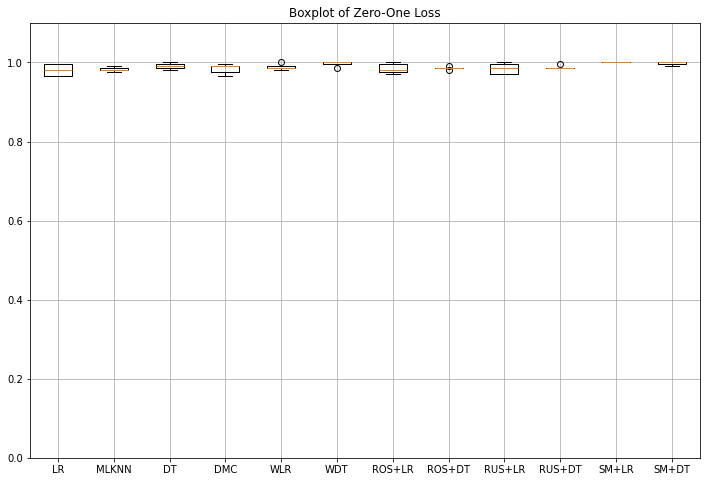

In [4]:
dataZeroOne = [
    stock_zeroOne_LR, stock_zeroOne_mlknn, stock_zeroOne_DT,
    stock_zeroOne_DMC, stock_zeroOne_WLR, stock_zeroOne_WDT,
    stock_zeroOne_ROS_LR, stock_zeroOne_ROS_DT, stock_zeroOne_RUS_LR, 
    stock_zeroOne_RUS_DT, stock_zeroOne_SMOTE_LR, stock_zeroOne_SMOTE_DT
]
# Calculate averages and standard deviation
promedios = [np.mean(d) for d in dataZeroOne]
desviaciones = [np.std(d) for d in dataZeroOne]

#  Create a list of averages ± standard deviations
promedios_desviacionesZeroOne = [f"{prom:.2f} ± {desv:.2f}" for prom, desv in zip(promedios, desviaciones)]

# Create a DataFrame with the data
df = pd.DataFrame({
    'Model': model_names,
    'Mean ± Std': promedios_desviacionesZeroOne
})



# Plot boxplot
plt.figure(figsize=(12, 8)) 
plt.boxplot(dataZeroOne, labels=model_names)
plt.title('Boxplot of Zero-One Loss')
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()


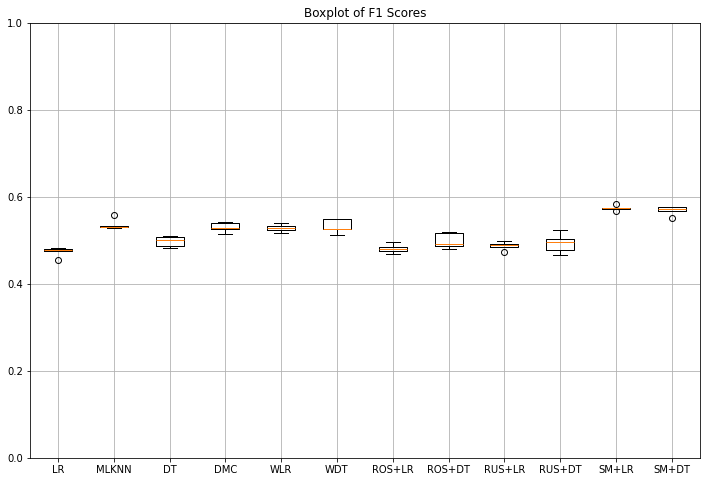

In [9]:
dataF1 = [
    stock_f1_LR, stock_f1_mlknn, stock_f1_DT,
    stock_f1_DMC, stock_f1_WLR, stock_f1_WDT,
    stock_f1_ROS_LR, stock_f1_ROS_DT, stock_f1_RUS_LR, 
    stock_f1_RUS_DT, stock_f1_SMOTE_LR, stock_f1_SMOTE_DT
]
promedios = [np.mean(d) for d in dataF1]
desviaciones = [np.std(d) for d in dataF1]

promedios_desviacionesF1 = [f"{prom:.2f} ± {desv:.2f}" for prom, desv in zip(promedios, desviaciones)]

df = pd.DataFrame({
    'Model': model_names,
    'Mean ± Std': promedios_desviacionesF1
})


plt.figure(figsize=(12, 8)) 
plt.boxplot(dataF1, labels=model_names)
plt.title('Boxplot of F1 Scores')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

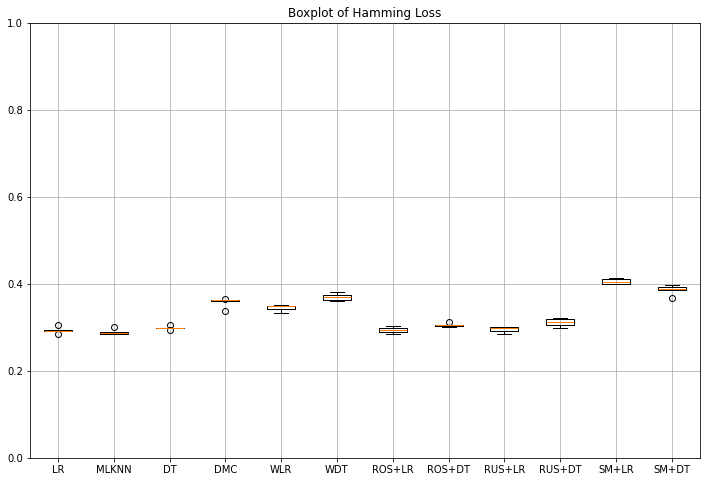

In [10]:
dataHamming = [
    stock_hamming_LR, stock_hamming_mlknn, stock_hamming_DT,
    stock_hamming_DMC, stock_hamming_WLR, stock_hamming_WDT,
    stock_hamming_ROS_LR, stock_hamming_ROS_DT, stock_hamming_RUS_LR,
    stock_hamming_RUS_DT, stock_hamming_SMOTE_LR, stock_hamming_SMOTE_DT
]

promedios = [np.mean(d) for d in dataHamming]
desviaciones = [np.std(d) for d in dataHamming]

promedios_desviacionesHamming = [f"{prom:.2f} ± {desv:.2f}" for prom, desv in zip(promedios, desviaciones)]

df = pd.DataFrame({
    'Model': model_names,
    'Mean ± Std': promedios_desviacionesHamming
})

# Graficar boxplot
plt.figure(figsize=(12, 8)) 
plt.boxplot(dataHamming, labels=model_names)
plt.title('Boxplot of Hamming Loss')
plt.grid(True)
plt.ylim(0, 1)
plt.show()

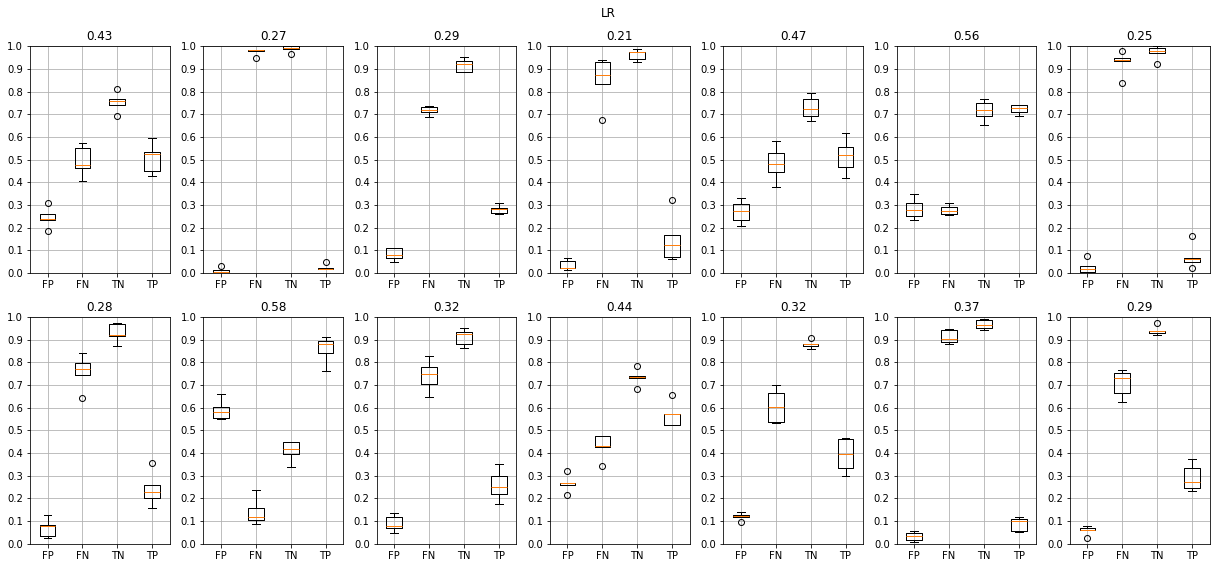

In [12]:
#LR graph
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_LR[:, 1, indices[i]], stock_rates_LR[:, 2, indices[i]], 
                stock_rates_LR[:, 0, indices[i]], stock_rates_LR[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])  # Establecer ticks en incrementos de 0.1
plt.suptitle('LR')
plt.tight_layout()
plt.show()

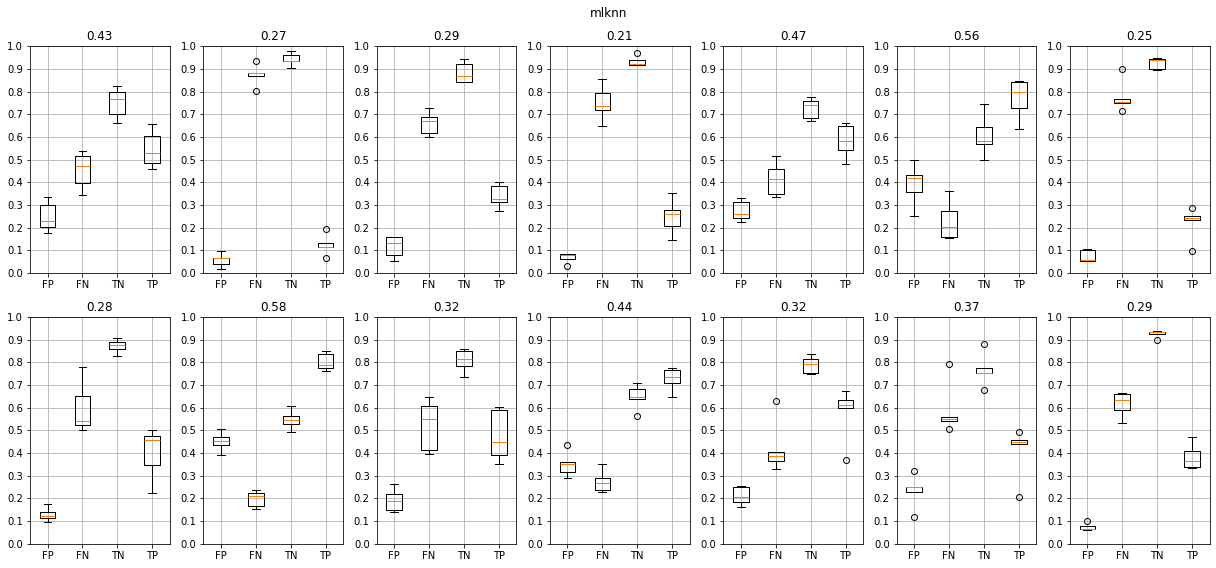

In [13]:
#MLkNN graph
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_mlknn[:, 1, indices[i]], stock_rates_mlknn[:, 2, indices[i]], 
                stock_rates_mlknn[:, 0, indices[i]], stock_rates_mlknn[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])  # Establecer ticks en incrementos de 0.1
plt.suptitle('mlknn')
plt.tight_layout()
plt.show()


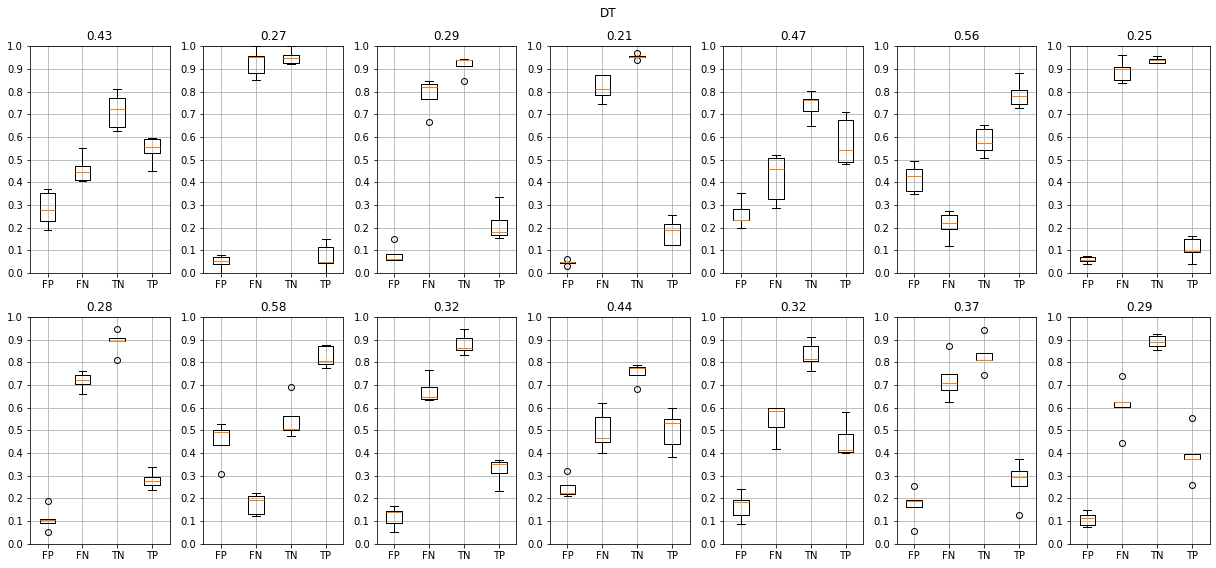

In [14]:
#DF graph
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_DT[:, 1, indices[i]], stock_rates_DT[:, 2, indices[i]], 
                stock_rates_DT[:, 0, indices[i]], stock_rates_DT[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])  # Establecer ticks en incrementos de 0.1
plt.suptitle('DT')
plt.tight_layout()
plt.show()

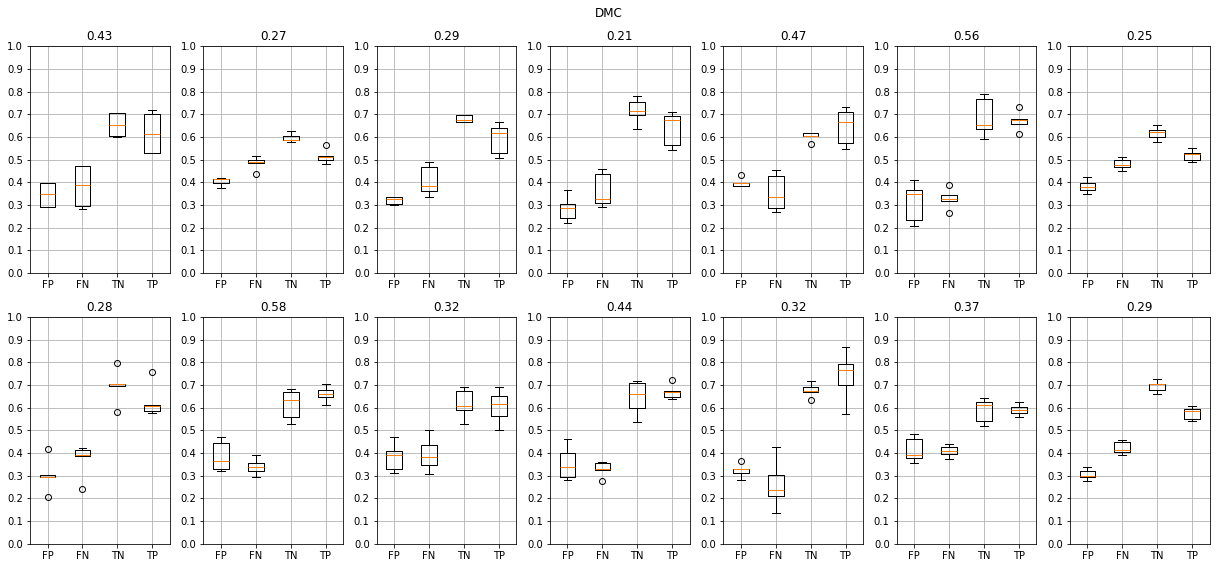

In [15]:
#DMC graph
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_DMC[:, 1, indices[i]], stock_rates_DMC[:, 2, indices[i]], 
                stock_rates_DMC[:, 0, indices[i]], stock_rates_DMC[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])  # Establecer ticks en incrementos de 0.1
plt.suptitle('DMC')
plt.tight_layout()
plt.show()

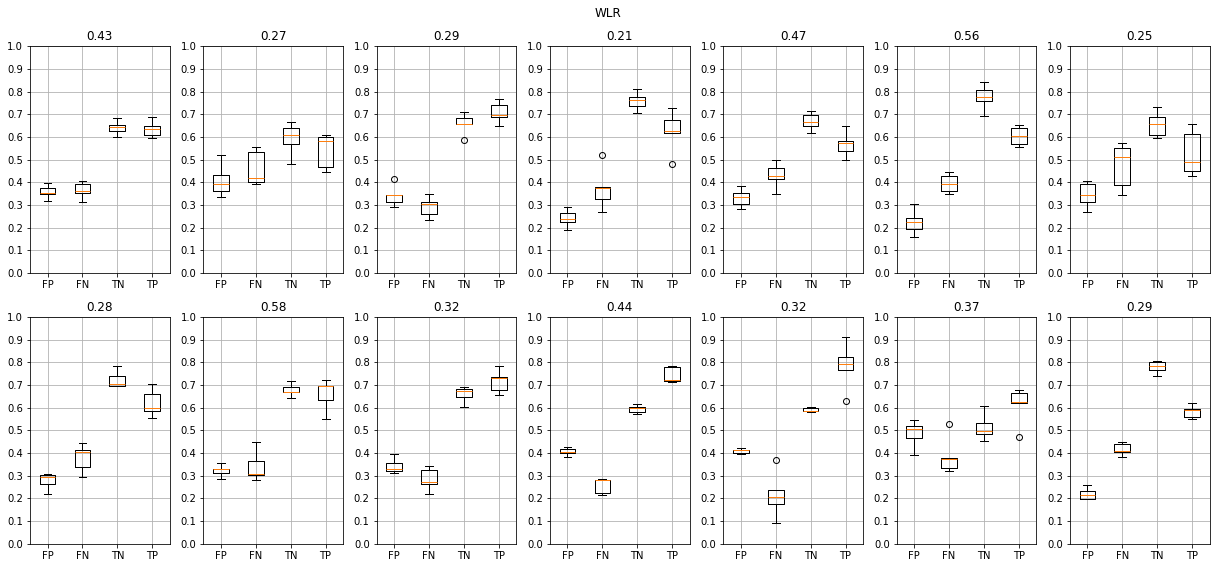

In [16]:
#Graph WLR
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_WLR[:, 1, indices[i]], stock_rates_WLR[:, 2, indices[i]], stock_rates_WLR[:, 0, indices[i]], stock_rates_WLR[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('WLR')
plt.tight_layout()
plt.show()

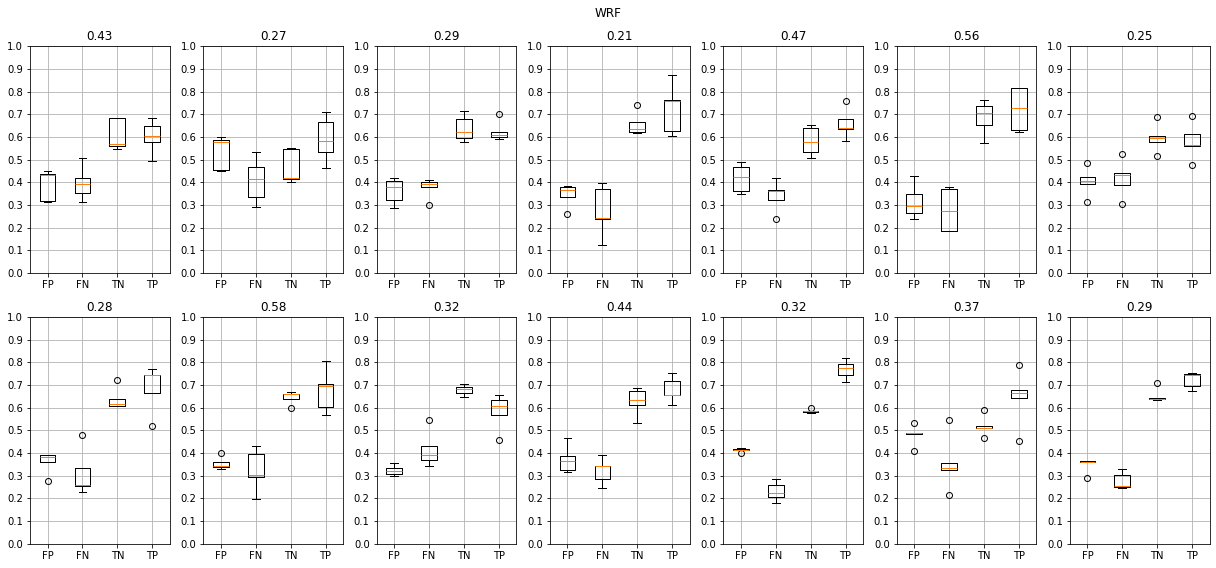

In [17]:
#Graph WDT
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_WDT[:, 1, indices[i]], stock_rates_WDT[:, 2, indices[i]], 
                stock_rates_WDT[:, 0, indices[i]], stock_rates_WDT[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('WRF')
plt.tight_layout()
plt.show()

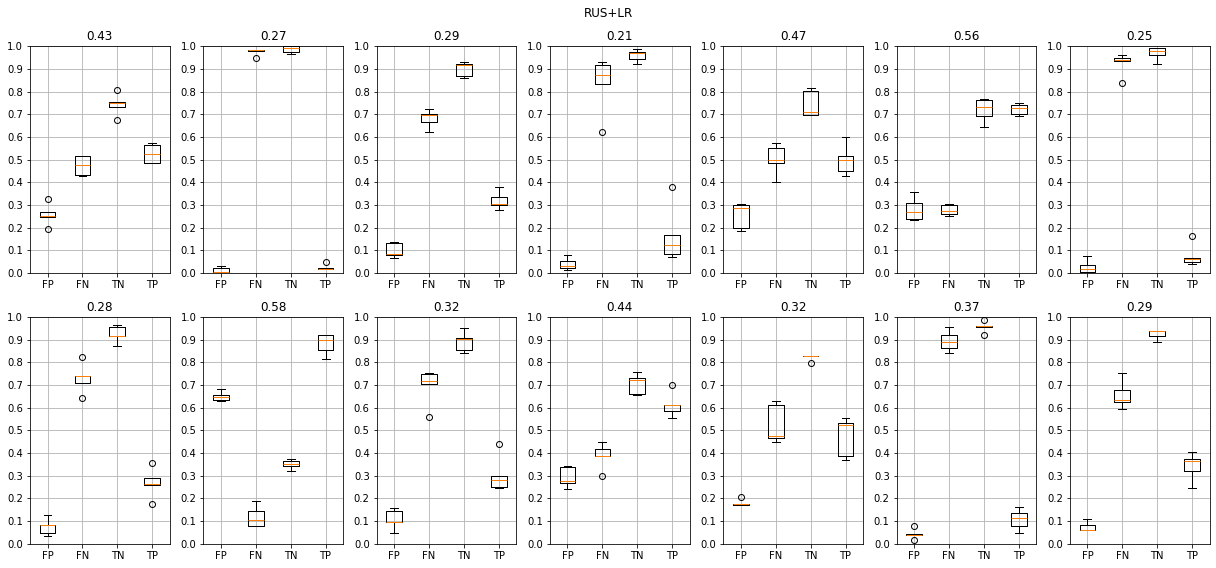

In [18]:
#Graph RUS+LR
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_RUS_LR[:, 1, indices[i]], stock_rates_RUS_LR[:, 2, indices[i]], 
                stock_rates_RUS_LR[:, 0, indices[i]], stock_rates_RUS_LR[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('RUS+LR')
plt.tight_layout()
plt.show()

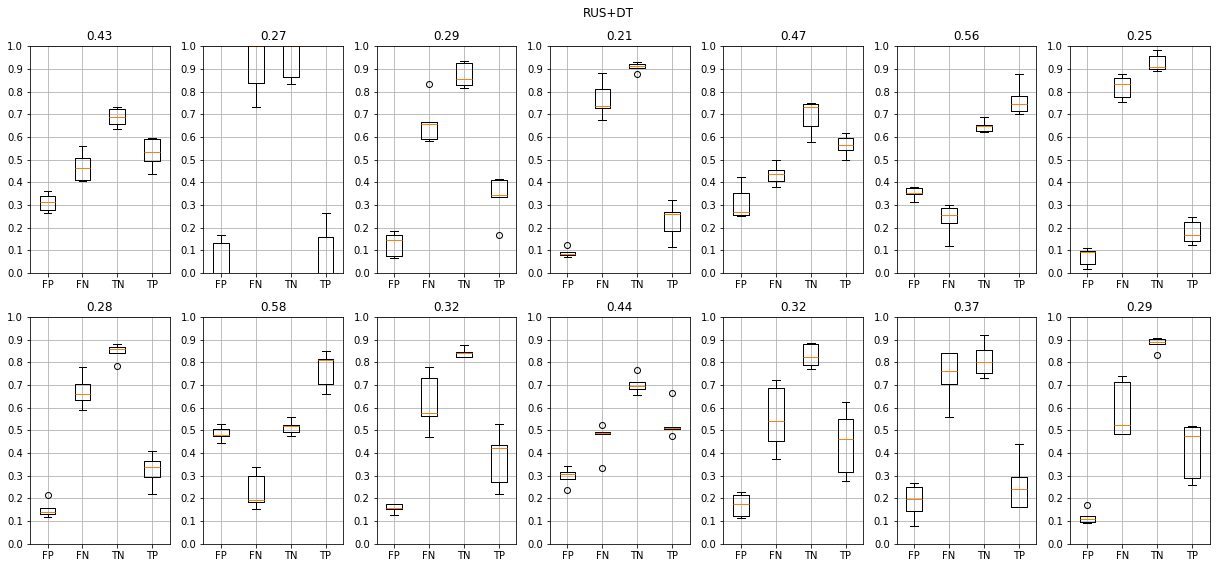

In [20]:
#Graph RUS+DT
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_RUS_DT[:, 1, indices[i]], stock_rates_RUS_DT[:, 2, indices[i]], 
                stock_rates_RUS_DT[:, 0, indices[i]], stock_rates_RUS_DT[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('RUS+DT')
plt.tight_layout()
plt.show()

In [ ]:
#Graph ROS+LR
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_ROS_LR[:, 1, indices[i]], stock_rates_ROS_LR[:, 2, indices[i]], 
                stock_rates_ROS_LR[:, 0, indices[i]], stock_rates_ROS_LR[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('ROS+LR')
plt.tight_layout()
plt.show()

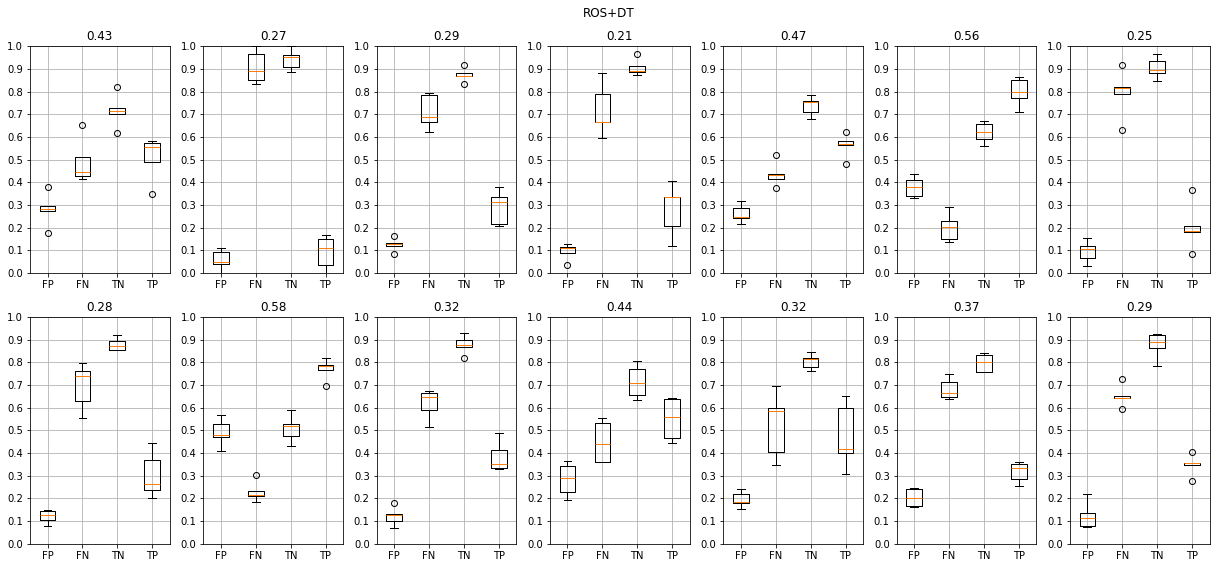

In [21]:
#Graph ROS+DT
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_ROS_DT[:, 1, indices[i]], stock_rates_ROS_DT[:, 2, indices[i]], 
                stock_rates_ROS_DT[:, 0, indices[i]], stock_rates_ROS_DT[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('ROS+DT')
plt.tight_layout()
plt.show()

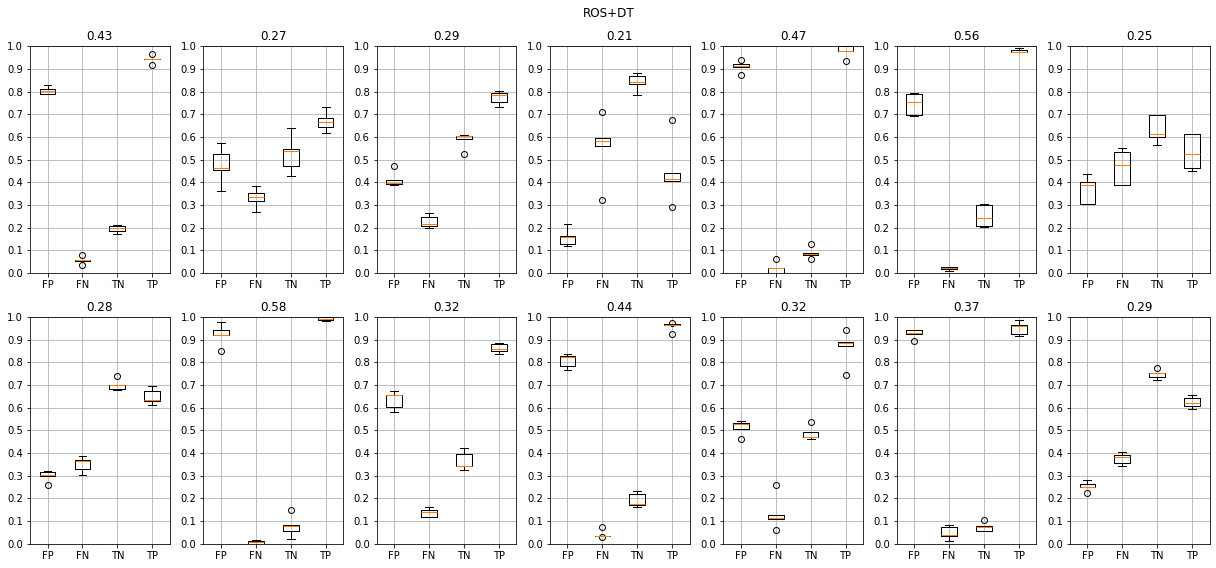

In [22]:
#Graph SMOTE+LR
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_SMOTE_LR[:, 1, indices[i]], stock_rates_SMOTE_LR[:, 2, indices[i]], 
                stock_rates_SMOTE_LR[:, 0, indices[i]], stock_rates_SMOTE_LR[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('SMOTE+LR')
plt.tight_layout()
plt.show()

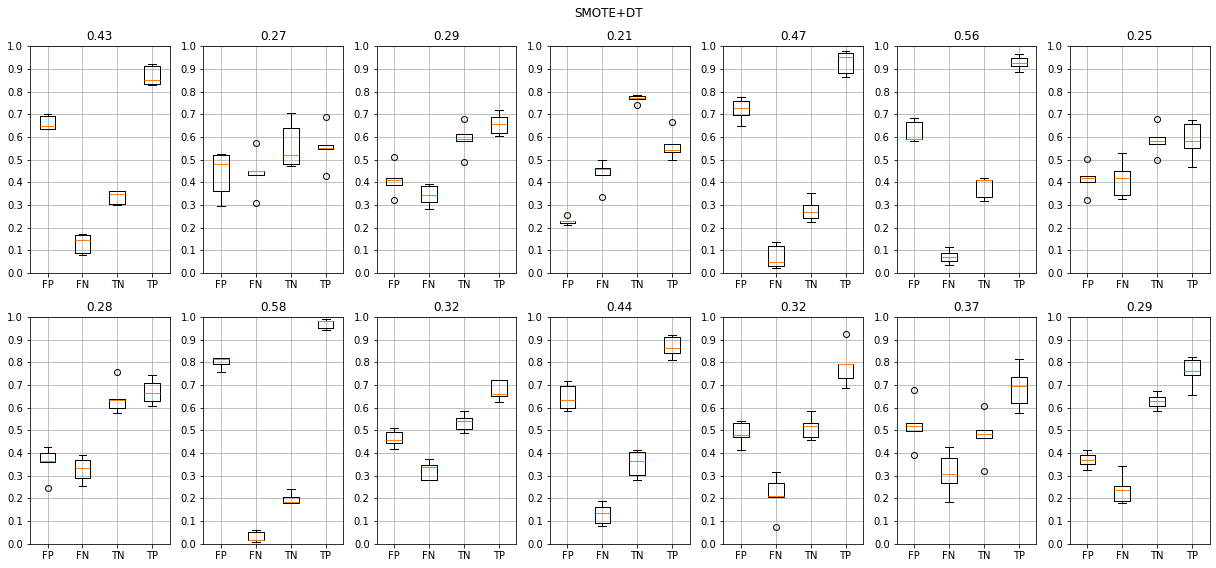

In [23]:
#Graph SMOTE+DT
fig, axes = plt.subplots(2, 7, figsize=(17, 8))
indices=[i for i in range(14)]
for i, ax in enumerate(axes.flat):
    ax.boxplot([stock_rates_SMOTE_DT[:, 1, indices[i]], stock_rates_SMOTE_DT[:, 2, indices[i]], 
                stock_rates_SMOTE_DT[:, 0, indices[i]], stock_rates_SMOTE_DT[:, 3, indices[i]]],
               labels=['FP', 'FN', 'TN', 'TP'])
    ax.set_title(f'{round(w[indices[i]],2)}')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.set_yticks([j / 10 for j in range(0, 11)])
plt.suptitle('SMOTE+DT')
plt.tight_layout()
plt.show()

In [24]:
dataPhi = [
    stock_phi_LR, stock_phi_mlknn, stock_phi_DT,
    stock_phi_DMC, stock_phi_WLR, stock_phi_WDT,
    stock_phi_ROS_LR, stock_phi_ROS_DT, stock_phi_RUS_LR,
    stock_phi_RUS_DT, stock_phi_SMOTE_LR, stock_phi_SMOTE_DT
]

# Calcular promedios y desviaciones estándar para phi
promedios_phi = [np.mean(d) for d in dataPhi]
desviaciones_phi = [np.std(d) for d in dataPhi]

# Crear una lista de promedios ± desviaciones estándar para phi
promedios_desviacionesPhi = [f"{prom:.2f} ± {desv:.2f}" for prom, desv in zip(promedios_phi, desviaciones_phi)]

# Crear un DataFrame con los datos para phi
df_phi = pd.DataFrame({
    'Metric': ['phi'] * len(model_names),
    'Classifier': model_names,
    'Dataset': promedios_desviacionesPhi
})

# Mostrar el DataFrame con las filas agregadas sin el índice
print(df_phi.to_string(index=False))

Metric Classifier     Dataset
   phi         LR 0.97 ± 0.03
   phi      MLKNN 0.84 ± 0.03
   phi         DT 0.91 ± 0.05
   phi        DMC 0.18 ± 0.01
   phi        WLR 0.25 ± 0.05
   phi        WDT 0.25 ± 0.04
   phi     ROS+LR 0.95 ± 0.03
   phi     ROS+DT 0.85 ± 0.10
   phi     RUS+LR 0.96 ± 0.03
   phi     RUS+DT 0.92 ± 0.10
   phi      SM+LR 0.93 ± 0.03
   phi      SM+DT 0.77 ± 0.04
